

## **Analysis of CROCO simulations for the Humboldt current system**. 
### Improvements of NCCHILE/Orlando simulation - Experiment (1): Control simulation

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmaps
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import geopandas as gpd
import xesmf as xe
import glob
import regionmask
import xgcm
import dask
import os
from dask.diagnostics import ProgressBar

plt.rc('font', size=16)
plt.rc('font', size=16)


The first thing to do is evaluate the improvements that may come when changing the ocean and atmospheric forcing to **GLORYS12V1 MERCATOR** and **ERA5-ECMWF** reanalysis. With this objetive in mind im going to run new simulations for 2006-2007 on different configurations keeping in mind a two years spin-up period. 2006-2007 is chosen as a key period because of the aviable data of the ncchile simulation (ends in 2008) and for the aviable gridded L4 satellite references (OSTIA begins in 2006, MUR in 2002). 

The first experiment consists of an equivalent configuration of the original NCCHILE simulation but with the new forcings, the atmospheric forcing is built from the daily means of ERA5 bulk variables **(uwnd, vwnd, radsw, radlw_in, radlw, wspd ,prate ,rhum and tair)** which are read by the simulation on a daily frequency along with GLORYS12V1 daily data. 

The spatial domain and grid of the ncchile simulation and this new model are presented below:


In [2]:
#GEBCO2021 Topobathymetry
gebco = xr.open_dataset('~/storage/GEBCO_SOUTHEASTPACIFIC.nc').topo
gebco = gebco.sel(lat=slice(-35,-26), lon=slice(-80,-69))

#Load grid data
coastmask   = gpd.read_file('~/storage/VECTORIAL/limites/ChileCOASTMASK.shp')
coastline   = gpd.read_file('~/storage/VECTORIAL/limites/lnealitoral/lineadecosta.shp')
#GLORYS12V1 Reference/Forcing model
grid_glorys = xr.open_dataset('data/GLORYS12V1/static/GLO-MFC_001_030_mask_bathy.nc').load()
grid_glorys = grid_glorys.rename({'latitude':'lat','longitude':'lon'})
grid_glorys = grid_glorys.sel(lat=slice(-35,-20),lon=slice(-83,-68))

#Original NCCHILE model
grid_ncchile = xr.open_dataset('data/NCCHILE/ncchile_grd.nc').load()
grid_ncchile = grid_ncchile[['h','xi_rho','eta_rho','lon_rho','lat_rho','x_rho','y_rho','mask_rho']]
grid_ncchile['lon_rho'] = (grid_ncchile.lon_rho+180)%360-180

#My model
grid = xr.open_dataset('data/CROCO/OUTPUT/TESTSIM/24HERA5_GLORYS12V1/testsim_grd.nc').squeeze().load()
grid = grid[['h','xi_rho','eta_rho','lon_rho','lat_rho','x_rho','y_rho','mask_rho']]
grid['lon_rho'] = (grid.lon_rho+180)%360-180
grid

<xarray.Dataset>
Dimensions:   (eta_rho: 294, xi_rho: 325)
Coordinates:
  * xi_rho    (xi_rho) int64 0 1 2 3 4 5 6 7 ... 317 318 319 320 321 322 323 324
  * eta_rho   (eta_rho) int64 0 1 2 3 4 5 6 7 ... 287 288 289 290 291 292 293
Data variables:
    h         (eta_rho, xi_rho) float32 433.6 433.6 450.8 ... 10.0 10.0 10.0
    lon_rho   (eta_rho, xi_rho) float32 -79.0 -78.97 -78.94 ... -70.03 -70.0
    lat_rho   (eta_rho, xi_rho) float32 -34.0 -34.0 -34.0 ... -27.0 -27.0 -27.0
    x_rho     (eta_rho, xi_rho) float32 -0.03125 2.557e+03 ... 8.912e+05
    y_rho     (eta_rho, xi_rho) float32 -0.03125 -0.03125 ... 7.784e+05
    mask_rho  (eta_rho, xi_rho) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                     North-Central Chile
    date:                      05-Dec-2022
    type:                      CROCO grid file
    history:                   Fri Jan 27 13:40:48 2023: ncpdq -L 5 -7 backup...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

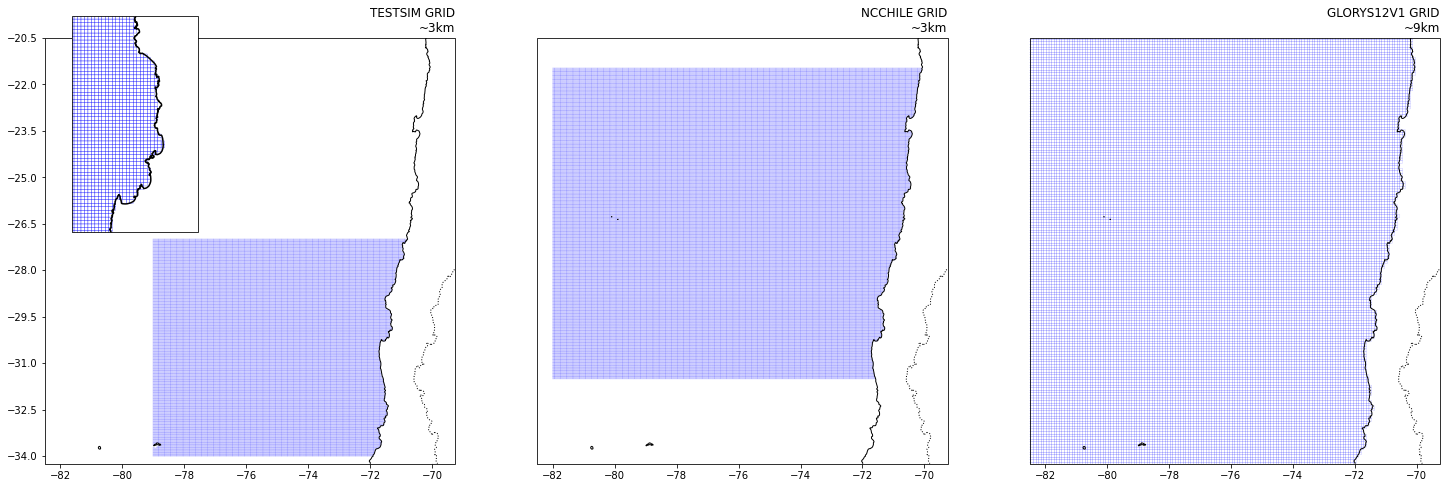

In [3]:
#Plot grids

plt.rc('font',size=16)
fig, ax = plt.subplots(1,3, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(25,15), sharex=True, sharey=True)
for axis in ax:
    axis.set_extent([-82.5,-69.25,-34.25,-21.25])
    axis.coastlines(zorder=3)
    # axis.gridlines(draw_labels=True, linewidth=0)
    axis.add_feature(cf.BORDERS, zorder=3, linestyle=":")
    axis.set_xticks(np.arange(-82,-68,2))
ax[0].set_yticks(np.arange(-34,-20,1.5));

box   = ax[0].get_position()
inset = fig.add_axes([box.xmin, box.ymax-0.18, 0.1,0.2], projection=ccrs.PlateCarree())
inset.pcolor(grid.lon_rho,grid.lat_rho, grid.mask_rho.where(grid.mask_rho==1), facecolor='none', edgecolor='blue', zorder=1, linewidth=0.25)
coastline.plot(ax=inset, color='k')
inset.set_xlim(-72,-71)
inset.set_ylim(-30.5,-29)
inset.set_xticks([])
inset.set_yticks([])

ax[0].pcolor(grid.lon_rho,grid.lat_rho, grid.mask_rho.where(grid.mask_rho==1), facecolor='none', edgecolor='blue', zorder=1, linewidth=0.05)
ax[1].pcolor(grid_ncchile.lon_rho,grid_ncchile.lat_rho, grid_ncchile.mask_rho.where(grid_ncchile.mask_rho==1), facecolor='none', edgecolor='blue', zorder=1, linewidth=0.05)
ax[2].pcolor(grid_glorys.lon,grid_glorys.lat, grid_glorys.mask[0].where(grid_glorys.mask[0]==1), facecolor='none', edgecolor='blue', zorder=1, linewidth=0.1)

ax[0].set_title('TESTSIM GRID\n~3km', loc='right')
ax[1].set_title('NCCHILE GRID\n~3km', loc='right')
ax[2].set_title('GLORYS12V1 GRID\n~9km', loc='right')
plt.show()

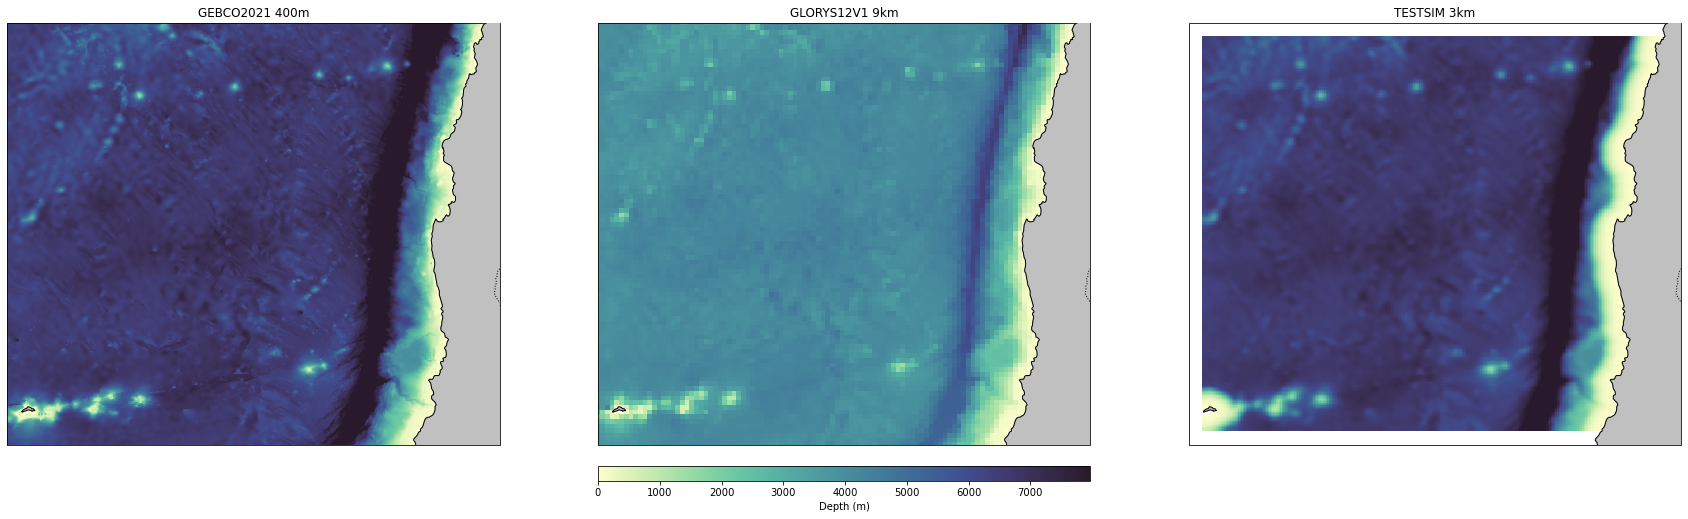

In [4]:
plt.rc('font',size=16)
%matplotlib inline
fig, ax = plt.subplots(1,3, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(30,20), sharex=True, sharey=True)

titles=['GEBCO2021 400m','GLORYS12V1 9km','TESTSIM 3km']
for i,axis in enumerate(ax.ravel()):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines('10m',zorder=4)
    axis.add_feature(cf.BORDERS, zorder=4, linestyle=":")
    axis.add_feature(cf.LAND, color='silver', zorder=3)
    axis.set_title(titles[i])
    
box = ax[1].get_position()
cax = fig.add_axes([box.xmin, box.ymin-0.025, box.xmax-box.xmin, 0.01])

cmap=cmocean.cm.deep
vmin,vmax=0,5e3
ax[0].pcolormesh(gebco.lon,gebco.lat,gebco*-1, zorder=0, cmap=cmap, vmin=vmin, vmax=vmax)
m=ax[1].pcolormesh(grid_glorys.lon, grid_glorys.lat, grid_glorys.deptho, cmap=cmap, vmin=vmin, zorder=0)
ax[2].pcolormesh(grid.lon_rho, grid.lat_rho, grid.h.where(grid.mask_rho==1), vmin=vmin, vmax=vmax, cmap=cmap, zorder=0)
fig.colorbar(m, cax=cax, orientation='horizontal', label='Depth (m)')
plt.show()

The original ncchile grid extends from 21°S to 31.5°S parallels while this new "testsim" domain is northward limited to 27°S and southward to 34°S. The grids extend westward from the Southamerican coast to 79°W (new one) and 82°W (old ncchile). The grid shrinking decision was mainly for the computation issue, because in this smaller domain the 4 year simulations can run more quickly. The final simulation will run from the same extent but limited northward to 21°S (ncchilev2 grid not shown). This new domain holds the complete Coquimbo region, so its original purpose (evaluate NCCHILE temperature improvements) remains unchanged. Because this simulation must reproduce real upwelling dynamics is very important that the near-shore processes are well represented. With this in mind it is important for the atmospheric forcing to reproduce the near-coast wind-jet dynamics due to the known wind speed drop-off and the heat fluxes effects on the mixed layer (Orlando/Boris papers). Another important aspect is the model sea-floor, where it seen in the last figure that the bathymetry smoothing transform the known steep shelf to a very shallower one (Looks like in GLORYS the shelf is shallower than the real one, but less steep than the croco smoothing). That said, for my own limited knowledge the sensitivity of upwelling to the model shelf slope of the Coquimbo region hasnt been studied and i must make future experiments to evaluate that changes in the simulation.   

In the next cells I will analyze the different modelled sea surface temperatures and their biases against the satellite products OSTIA or MUR. As a first aproximation i will compute the spatial mean bias, root mean squared error and the squared of pearson correlation, next i will analyze temporal variations of the biases to check for systematic errors.

In [3]:
#Target dates for the analysis !
ttime = pd.date_range('2006-04','2008', freq='d')[:-1]

Loading OSTIA and MUR datasets for 2006 and 2007 ... 

In [4]:
#Load OSTIA reference dataset:
if os.path.exists('data/ZARR/ostia'):
    ostia = xr.open_zarr('data/ZARR/ostia').chunk({'time':1})
    ostia = ostia.chunk({'lat':len(ostia.lat),'lon':len(ostia.lon)})
else:
    raise FileNotFoundError('zarr store doesnt exists!')
ostia_clim = xr.open_dataset('~/storage/SST_CLIMATOLOGY_OSTIA.nc').rename({'analysed_sst':'sst'})
ostia

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 220, time: 640)
Coordinates:
  * lat      (lat) float32 -34.97 -34.92 -34.88 -34.83 ... -26.12 -26.08 -26.02
  * lon      (lon) float32 -79.97 -79.93 -79.88 -79.82 ... -69.12 -69.07 -69.03
  * time     (time) datetime64[ns] 2006-04-01 2006-04-02 ... 2007-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 180, 220), meta=np.ndarray>

Loading GLORYS12V1 reanalysis data for 2006 and 2007, sea surface temperature and meridional current ...

In [5]:
#Load GLORYS12V1 dataset:
if os.path.exists('data/ZARR/glorys12v1/'):
    glorys = xr.open_zarr('data/ZARR/glorys12v1/').chunk({'time':1})
    glorys = glorys.chunk({'lat':len(ostia.lat),'lon':len(ostia.lon),'depth':len(glorys.depth)})
else:
    raise FileNotFoundError('zarr store doesnt exists!')


glorys = glorys.sel(lat=slice(-35,-26.5), lon=slice(-80,-69)).chunk({'lat':len(ostia.lat),'lon':len(ostia.lon)})
glorys

<xarray.Dataset>
Dimensions:  (depth: 50, lat: 103, lon: 133, time: 640)
Coordinates:
  * depth    (depth) float64 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03
  * lat      (lat) float64 -35.0 -34.92 -34.83 -34.75 ... -26.67 -26.58 -26.5
  * lon      (lon) float64 -80.0 -79.92 -79.83 -79.75 ... -69.17 -69.08 -69.0
  * time     (time) datetime64[ns] 2006-04-01 2006-04-02 ... 2007-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 103, 133), meta=np.ndarray>
    temp     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 50, 103, 133), meta=np.ndarray>
    vo       (time, depth, lat, lon) float32 dask.array<chunksize=(1, 50, 103, 133), meta=np.ndarray>

Loading ncchile croco simulation for 2006 and 2007, sea surface temperature (first sigma level) and meridional currents ... 

With that task in mind i will develop some read functions for loading raw croco data into python. First a function for fixing the time coordinate (from numbers to datetime objects), then a function to interpolate the edge variables of the arakawa-C grid to the center of the grid, and finally the loading function. For the details check below.

In [6]:
def fix_crocotime(DATA,YORIG):
    """
    Grab simulation time and transform to datetime objects based on given YORIG

    Args:
        DATA (XDataset, XDataArray): CROCO simulation data, with "time" coordinate 
        YORIG (str): Given reference date

    Returns:
        XDataset, XDataArray: Data with fixed time coordinate
    """
    ORIG = pd.to_datetime(YORIG)
    new_time = pd.to_datetime([datetime.timedelta(seconds=t.item())+ORIG
                               for t in DATA.time])
    DATA['time'] = new_time
    return DATA.sortby('time')

def center_grid(data,variables):
    """
    This function grabs a croco model outputs and moves the 
    arakawa-C edges variables to the center of the grid.
    (like water velocities...) 

    Args:
        data (xarray): input dataset
        variables (list): list of variables to transform

    Returns:
        xarray: dataset with variables in the center of the grid 
    """
    for v in variables:
        if 'eta_v' in data[v].dims:
            x = data[v].interp(eta_v=data.eta_rho.values)
            x = x.rename({'eta_v':'eta_rho'})
            data = data.drop(v)
            data[v]=x
        elif 'xi_u' in data[v].dims:
            x = data[v].interp(xi_u=data.xi_rho.values)
            x = x.rename({'xi_u':'xi_rho'})
            data = data.drop(v)
            data[v]=x
        else:
            pass
    data = data.drop(['xi_u','eta_v', 'lon_v', 'lat_v','lon_u','lat_u'])
    return data

def load_croco(paths, YORIG, variables=None, **kwargs):
    """
    Loading function for reading raw CROCO/ROMS outputs into
    xarray objects. **kwargs are passed to xarray.open_dataset() function

    Args:
        paths (str, list): _description_
        YORIG (str): _description_
        variables (list, optional): _description_. Defaults to None.

    Raises:
        ValueError: If input path is not a string or list of strings

    Returns:
        xarray: loaded croco data
    """
    if type(paths) == str:
        if "*" in paths:
            data = xr.open_mfdataset(paths,
                                    concat_dim='time',
                                    combine='nested',
                                    **kwargs)
            data = fix_crocotime(data, YORIG)
        else:
            data = xr.open_dataset(paths, **kwargs)
            data = fix_crocotime(data, YORIG)
    elif type(paths) == list:
        data=[]
        for p in paths:
            d = xr.open_dataset(p, **kwargs)
            d = fix_crocotime(d,YORIG)
            data.append(d)
        data = xr.concat(data,'time')
    else:
        raise ValueError('Path to croco output should only be a string or a list of strings.')
    if variables==None:
        data = center_grid(data, data.keys())
    else:
        data = center_grid(data, variables)[variables]
    return data.sortby('time')

def croco_sellonlatbox(data, lonmin, lonmax, latmin, latmax):
    """
    This functions grabs a croco output and slice it to the
    desired latlon bounds. 
    Only works for rho point centered variables (like temp, salt, zeta, etc)
    Other arakawa-C grid variables like zonal and meridional currents must first
    be horizontally interpolated to the grid center.

    Args:
        data (xarray): loaded dataset (centered in rho points) as xarray object
        lonmin (float): min longitude
        lonmax (float): max longitude
        latmin (float): min latitude
        latmax (float): max latitude

    Returns:
        data: sliced data to the user defined latlon box 
    """
    data = data.sortby('eta_rho').sortby('xi_rho')
    geoindex = ((data.lon_rho > lonmin) & (data.lon_rho<lonmax) & (data.lat_rho>latmin) & (data.lat_rho < latmax)).load()
    geoindex = np.argwhere(geoindex.values)
    xmin = min(geoindex[:,1])
    xmax = max(geoindex[:,1])
    ymin = min(geoindex[:,0])
    ymax = max(geoindex[:,0])
    data = data.sel(eta_rho=slice(ymin,ymax), xi_rho=slice(xmin,xmax))
    return data

In [7]:
#Load NCCHILE dataset:
if os.path.exists('data/ZARR/ncchile'):
    ncchile = xr.open_zarr('data/ZARR/ncchile').chunk({'time':1,'s_rho':50})
    ncchile['lon_rho'] = (ncchile['lon_rho']+180)%360-180
else:
    raise FileExistsError('zarr store doest exists!')

ncchile = ncchile.chunk({'eta_rho':len(ncchile.eta_rho),'xi_rho':len(ncchile.xi_rho)})
ncchile['lon_rho'] = ncchile.lon_rho.load()
ncchile['lat_rho'] = ncchile.lat_rho.load()
ncchile = croco_sellonlatbox(ncchile, -80, -69, -35, -26.5)
ncchile

<xarray.Dataset>
Dimensions:  (eta_rho: 205, xi_rho: 359, s_rho: 50, time: 640)
Coordinates:
  * eta_rho  (eta_rho) float64 1.0 2.0 3.0 4.0 5.0 ... 202.0 203.0 204.0 205.0
    lat_rho  (eta_rho, xi_rho) float32 -31.5 -31.5 -31.5 ... -26.55 -26.55
    lon_rho  (eta_rho, xi_rho) float32 -80.0 -79.97 -79.94 ... -70.08 -70.06
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
  * time     (time) datetime64[ns] 2006-04-01 2006-04-02 ... 2007-12-31
  * xi_rho   (xi_rho) float32 73.0 74.0 75.0 76.0 ... 428.0 429.0 430.0 431.0
Data variables:
    sst      (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 205, 359), meta=np.ndarray>
    temp     (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 50, 205, 359), meta=np.ndarray>
    v        (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 50, 205, 359), meta=np.ndarray>
    z_rho    (time, eta_rho, xi_rho, s_rho) float32 dask.array<chunksize=(1, 205, 359, 50), meta=np.ndarray>
    zeta     (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 205, 359), meta=np.ndarray>
Attributes: (12/60)
    CPP-options:    REGIONAL NCCHILE MPI OBC_WEST OBC_NORTH OBC_SOUTH CURVGRI...
    Cdb_expl:       Range of quadratic drag coefficientr
    Cdb_max:        0.10000000149011612
    Cdb_min:        9.999999747378752e-05
    Cs_r:           [-0.9772951602935791, -0.9277534484863281, -0.87368071079...
    Cs_r_expl:      S-coordinate stretching curves at RHO-points
    ...             ...
    type:           ROMS history file
    v_sponge:       0.0
    visc2:          0.0
    visc2_expl:     Laplacian mixing coefficient for momentum
    visc2_units:    meter2 second-1
    x_sponge:       0.0

Loading testsim croco simulation for 2006 and 2007, sea surface temperature (first sigma level) and meridional currents ... 

In [8]:
#Load test simulation dataset: 
if os.path.exists('data/ZARR/testsim_control'):
    simulation = xr.open_zarr('data/ZARR/testsim_control').chunk({'time':1,'s_rho':50})
else:
    raise FileExistsError('zarr store doesnt exists!')

simulation = simulation.chunk({'eta_rho':len(simulation.eta_rho),'xi_rho':len(simulation.xi_rho)})
simulation['lon_rho'] = simulation.lon_rho.load()
simulation['lat_rho'] = simulation.lat_rho.load()
simulation

<xarray.Dataset>
Dimensions:  (eta_rho: 293, xi_rho: 324, s_rho: 50, time: 730)
Coordinates:
  * eta_rho  (eta_rho) float64 1.0 2.0 3.0 4.0 5.0 ... 290.0 291.0 292.0 293.0
    lat_rho  (eta_rho, xi_rho) float32 -34.0 -34.0 -34.0 ... -27.02 -27.02
    lon_rho  (eta_rho, xi_rho) float32 -79.0 -78.97 -78.94 ... -70.06 -70.03
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
  * time     (time) datetime64[ns] 2006-01-01T12:01:15 ... 2007-12-31T12:01:15
  * xi_rho   (xi_rho) float32 1.0 2.0 3.0 4.0 5.0 ... 321.0 322.0 323.0 324.0
Data variables:
    sst      (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 293, 324), meta=np.ndarray>
    temp     (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 50, 293, 324), meta=np.ndarray>
    v        (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 50, 293, 324), meta=np.ndarray>
    z_rho    (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 50, 293, 324), meta=np.ndarray>
    zeta     (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 293, 324), meta=np.ndarray>

The reference and model data are now loaded into computer memory, so now calculations can me made (at the time no computation has been made). The mean bias, root mean squared error and correlation will be computed in the next cell, but in the first place an horizontal interpolation to a common grid (ostia) must be done. For that purpose the xesmf library will be used.

In [9]:
#Interpolate horizontal grids
reference        = ostia.reindex({'time':ttime},method='nearest')
clim             = ostia_clim.reindex({'lat':reference.lat.values,'lon':reference.lon.values})
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                    'lon':(['lon'], reference.lon.values, reference.lon.attrs)})

regridder        = xe.Regridder(glorys, reference, 'bilinear')
glorys_bias      = regridder(glorys['sst'].reindex({'time':ttime},method='nearest'))
glorys_corr      = xr.corr(glorys_bias, reference.sst, dim='time')
glorys_acorr     = xr.corr(glorys_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                          reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
glorys_bias      = glorys_bias-reference.sst

regridder        = xe.Regridder(ncchile.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
ncchile_bias     = regridder(ncchile['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).chunk({'eta_rho':len(ncchile.eta_rho),'xi_rho':len(ncchile.xi_rho)}))
ncchile_bias     = ncchile_bias.where(ncchile_bias>0).reindex({'time':ttime},method='nearest')
ncchile_corr     = xr.corr(ncchile_bias, reference.sst, dim='time')
ncchile_acorr    = xr.corr(ncchile_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                          reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
ncchile_bias     = ncchile_bias-reference.sst

regridder        = xe.Regridder(simulation.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
simulation_bias  = regridder(simulation['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).reindex({'time':ttime},method='nearest'))
simulation_corr  = xr.corr(simulation_bias.where(simulation_bias>0), reference.sst, dim='time')
simulation_acorr = xr.corr(simulation_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                          reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
simulation_bias  = simulation_bias.where(simulation_bias>0)-reference.sst


/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Now that i have the time series of each model bias i can plot the mean bias, rmse and correlations in a map...

[########################################] | 100% Completed | 77.95 s
[########################################] | 100% Completed | 31.61 s


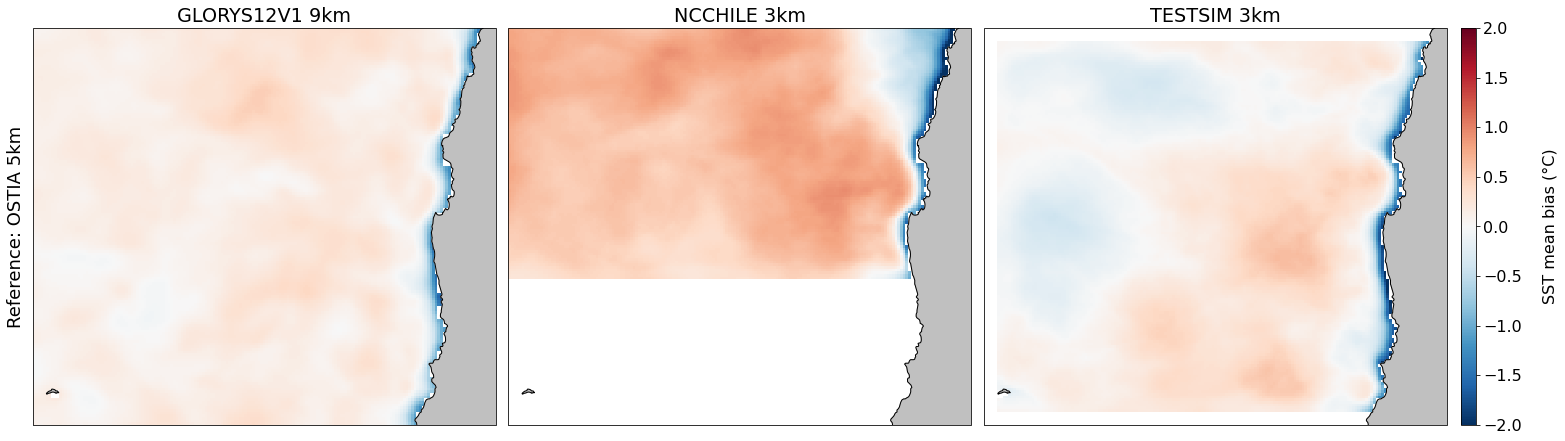

In [24]:
#Plot mean SST bias against reference (OSTIA)
with ProgressBar():
    plt.rc('font',size=16)
    fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
    fig.tight_layout(pad=0.8)
    titles    = ['GLORYS12V1 9km','NCCHILE 3km','TESTSIM 3km']

    for i,axis in enumerate(ax):
        axis.set_extent([-79.25,-70.5,-34.25,-26.75])
        axis.coastlines(zorder=3)
        axis.add_feature(cf.LAND, zorder=2, color='silver')
        axis.set_title(titles[i])

    ax[0].set_yticks([])
    ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
    box = ax[-1].get_position()
    cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

    cmap='RdBu_r'
    norm=mcolors.Normalize(-2,2)
    m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, glorys_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
    ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
    ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
    fig.colorbar(m,cax=cax, label='\nSST mean bias (°C)')

[########################################] | 100% Completed | 52.00 s
[########################################] | 100% Completed | 75.80 s
[########################################] | 100% Completed | 30.42 s


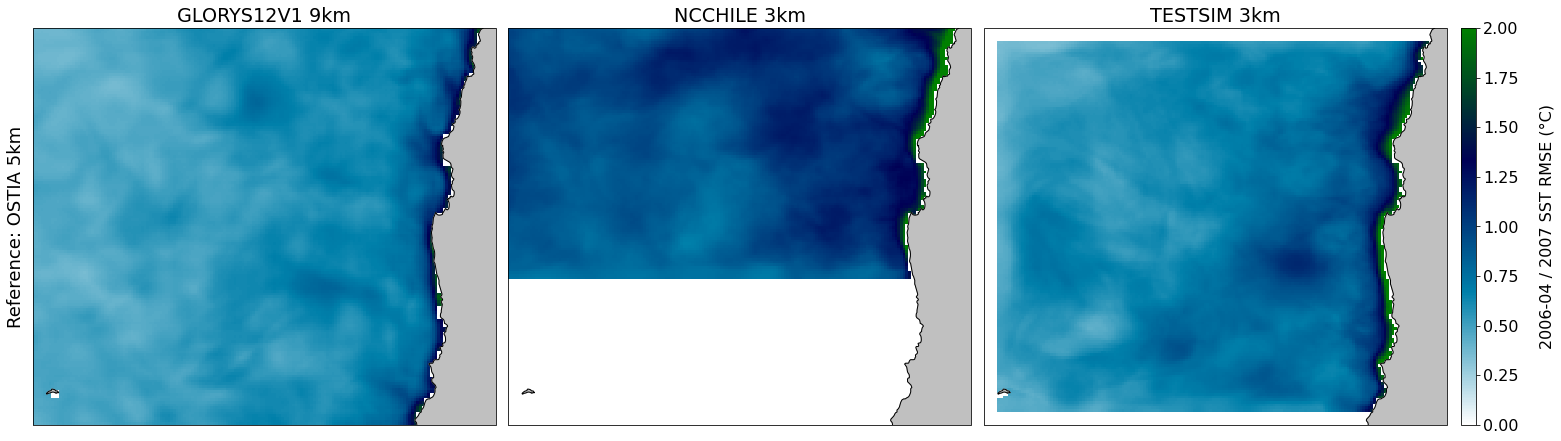

In [15]:
#Plot SST RMSE against reference (OSTIA)
with ProgressBar():
    plt.rc('font',size=16)
    fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
    fig.tight_layout(pad=0.8)
    titles    = ['GLORYS12V1 9km','NCCHILE 3km','TESTSIM 3km']

    for i,axis in enumerate(ax):
        axis.set_extent([-79.25,-70.5,-34.25,-26.75])
        axis.coastlines(zorder=3)
        axis.add_feature(cf.LAND, zorder=2, color='silver')
        axis.set_title(titles[i])

    ax[0].set_yticks([])
    ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
    box = ax[-1].get_position()
    cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

    cmap='ocean_r'
    norm=mcolors.Normalize(0,2)
    m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, (glorys_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
    ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, (ncchile_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
    ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, (simulation_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
    fig.colorbar(m,cax=cax, label='\nSST RMSE (°C)')

[#####################################   ] | 94% Completed | 64.20 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 67.94 s


/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[######################################  ] | 96% Completed | 87.38 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 91.12 s
[####################################    ] | 91% Completed | 43.53 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 47.39 s


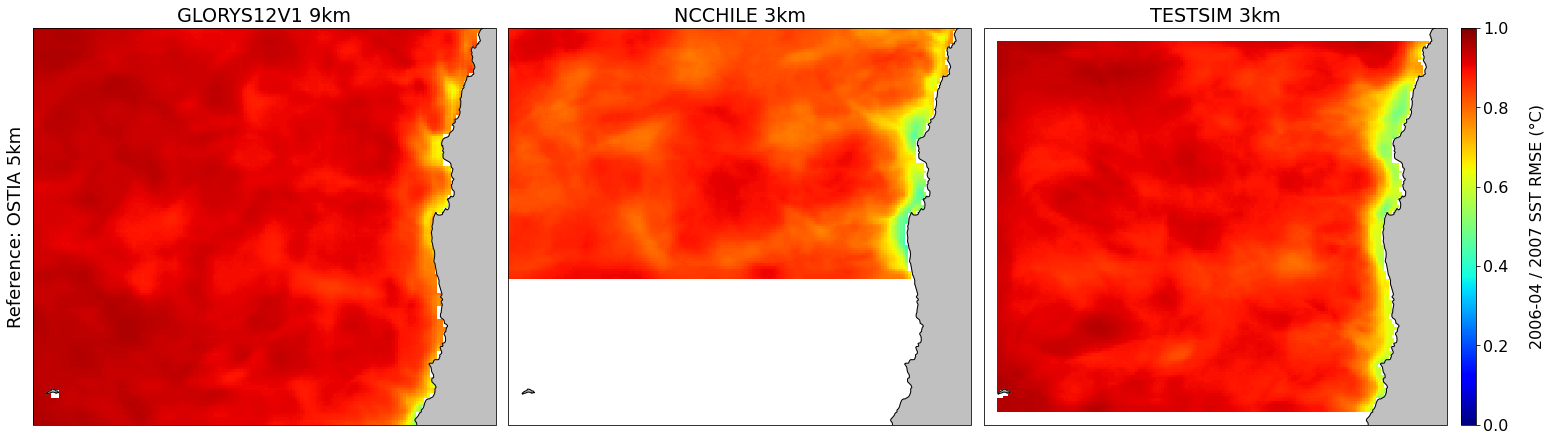

In [16]:
#Plot SST pearson correlation against reference (OSTIA)
with ProgressBar():
    plt.rc('font',size=16)
    fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
    fig.tight_layout(pad=0.8)
    titles    = ['GLORYS12V1 9km','NCCHILE 3km','TESTSIM 3km']

    for i,axis in enumerate(ax):
        axis.set_extent([-79.25,-70.5,-34.25,-26.75])
        axis.coastlines(zorder=3)
        axis.add_feature(cf.LAND, zorder=2, color='silver')
        axis.set_title(titles[i])

    ax[0].set_yticks([])
    ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
    box = ax[-1].get_position()
    cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

    cmap='jet'
    norm=mcolors.Normalize(0,1)
    m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, glorys_corr**2, rasterized=True, cmap=cmap, norm=norm)
    ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_corr**2, rasterized=True, cmap=cmap, norm=norm)
    ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_corr**2, rasterized=True, cmap=cmap, norm=norm)
    fig.colorbar(m,cax=cax, label='\nSST TOTAL $R^2$ (-)')

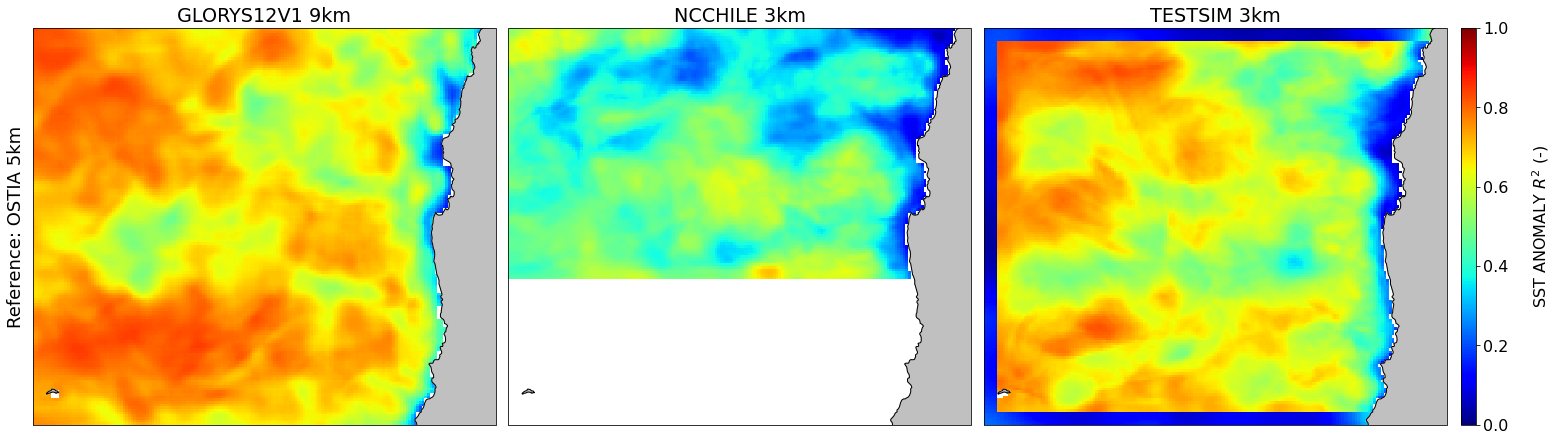

In [11]:
#Plot SST anomaly pearson correlation against reference (OSTIA)
with ProgressBar():
    plt.rc('font',size=16)
    fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
    fig.tight_layout(pad=0.8)
    titles    = ['GLORYS12V1 9km','NCCHILE 3km','TESTSIM 3km']

    for i,axis in enumerate(ax):
        axis.set_extent([-79.25,-70.5,-34.25,-26.75])
        axis.coastlines(zorder=3)
        axis.add_feature(cf.LAND, zorder=2, color='silver')
        axis.set_title(titles[i])

    ax[0].set_yticks([])
    ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
    box = ax[-1].get_position()
    cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

    cmap='jet'
    norm=mcolors.Normalize(0,1)
    m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, glorys_acorr**2, rasterized=True, cmap=cmap, norm=norm)
    ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_acorr**2, rasterized=True, cmap=cmap, norm=norm)
    ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_acorr**2, rasterized=True, cmap=cmap, norm=norm)
    fig.colorbar(m,cax=cax, label='\nSST ANOMALY $R^2$ (-)')

Now, with a coastal band mask i can grab only the data near the shore and make a spatial average to check for temporal variations in the mean bias ...

In [33]:
#Create coastal band mask from coast band polygon then compute timeseries from coast regional mean
with ProgressBar():
    mask = regionmask.mask_geopandas(coastmask, reference.lon, reference.lat)
    mask = mask==0
    mask = ((~np.isnan(ncchile_bias[0])) & mask).load()
    mask[:85]  = 0
    mask[-55:] = 0

    reference_coast       = reference['sst'].where(mask==1).mean(['lat','lon']).to_series()
    glorys_bias_coast     = glorys_bias.where(mask==1).mean(['lat','lon']).to_series()
    ncchile_bias_coast    = ncchile_bias.where(mask==1).mean(['lat','lon']).to_series()
    simulation_bias_coast = simulation_bias.where(mask==1).mean(['lat','lon']).to_series()

[########################################] | 100% Completed | 315.02 ms
[########################################] | 100% Completed | 25.82 s
[########################################] | 100% Completed | 54.56 s
[########################################] | 100% Completed | 77.23 s
[########################################] | 100% Completed | 31.04 s


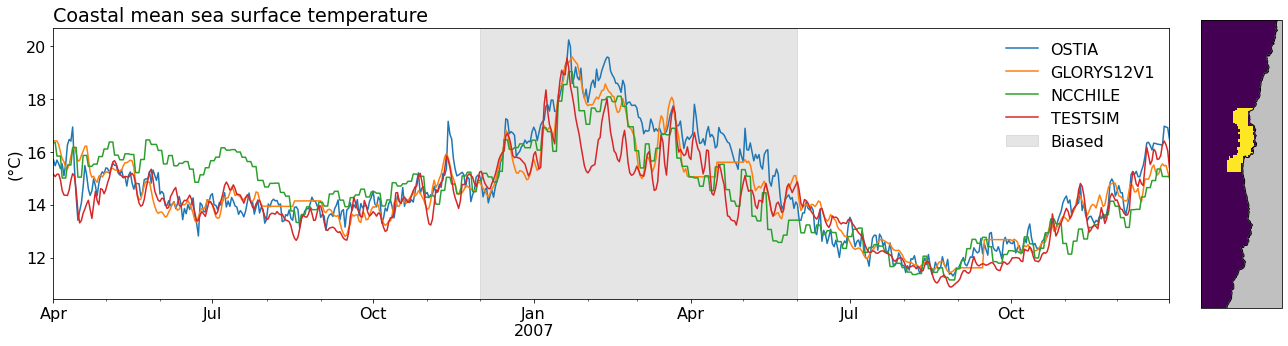

In [44]:
#Plot coast averages time series for each model

fig = plt.figure(figsize=(20,5))
reference_coast.plot(label='OSTIA')
(reference_coast+glorys_bias_coast).plot(label='GLORYS12V1')
(reference_coast+ncchile_bias_coast).plot(label='NCCHILE')
(reference_coast+simulation_bias_coast).plot(label='TESTSIM')
plt.axvspan("2006-12","2007-06", color='grey', alpha=0.2, label='Biased')
plt.legend(ncol=1, loc='upper right', frameon=False)
plt.xlabel("")
plt.ylabel("(°C)")
plt.title("Coastal mean sea surface temperature", loc='left')



inset = fig.add_axes([0.85,0.1,0.2,0.8], projection=ccrs.PlateCarree())
inset.coastlines(zorder=3)
inset.add_feature(cf.LAND, color='silver',zorder=2)
inset.pcolormesh(mask.lon,mask.lat, mask, zorder=0, transform=ccrs.PlateCarree(), rasterized=True, cmap='viridis')
inset.set_extent([-73,-70.5,mask.lat.min(), mask.lat.max()])

In [35]:
from scipy.stats import pearsonr
statistics = pd.DataFrame([], index=['GLORYS','NCCHILE','TESTSIM'], columns=['MBIAS','RMSE','R2'])
statistics['MBIAS'] = [x.mean() for x in [glorys_bias_coast, ncchile_bias_coast, simulation_bias_coast]]
statistics['RMSE']  = [(x**2).mean()**0.5 for x in [glorys_bias_coast, ncchile_bias_coast, simulation_bias_coast]]
statistics['R2']    = [pearsonr(x+reference_coast, reference_coast)[0]**2 for x in [glorys_bias_coast, ncchile_bias_coast, simulation_bias_coast]]
statistics

,MBIAS,RMSE,R2
GLORYS,-0.205270,0.699812,0.875247
NCCHILE,-0.136725,1.015149,0.715566
TESTSIM,-0.486050,0.946709,0.818420


Overall, it seems that this "raw" change of forcings improve the NCCHILE simulation. The open ocean warm bias seems to dimish along with the RMSE, probably due to better radiative fluxes, but it is strange that in the test simulation the mean bias isnt spatially homogeneous as it is in the GLORYS12 and NCCHILE datasets. Anyway, for the open ocean, and in relation with the illustrated GLORYS12 biases, it looks like the simulation bias is on average constrained to the (-0.5, 0.5)°C interval. Another aspect to take account is the wierd warm blob in front of Valparaíso (33°S) that may indicate that i have to extend the spin-up period... 

The greatest bias, greatest RMSE and lesser correlations happen near the coast, and in the **summer**, as it is expected for this eastern upwelling system. The new simulation continues to reproduce the ncchile/glorys cold coastal bias, which is known to be related with a wrong description of the near-coast wind drop-off. I did hope that ERA5 had a better representation of this drop-off, but i can only see small improvements in the near coast temperature pixels/time series. Another aspect, is that in this near-coast conditions the CROCO simulations (NCCHILE and TESTSIM) have greater biases and errors than the GLORYS12V1 reanalysis. For the TESTSIM simulation is expected an improvement against GLORYS12V1 due to the dynamical downscaling, but why the simulation is worse in the coast than its own forcing?, i can only think that the problem is in the atmospheric forcing, but to my knowledge the GLORYS12V1 reanalysis IS forced by ERA-Interim / ERA5, so why should be worse? I need to validate the simulation forcings in a different notebook.


Another thing to do for checking the origin of this biases is analyze what is happening in the water column, if there is something wrong with the atmospheric forcing the water column stratification should be affected, so i will take a quick look on the vertical structure of the currents. In the next cells i will grab the data in a cross section centered on 30°S (middle of Coquimbo bay) and check for differences on the mean meridional velocity.

In [38]:
#Cross section in a target latitude...
with ProgressBar():
    tlat = -30.5
    ncchile_eta    = np.where(np.sign(ncchile.lat_rho-tlat).diff('eta_rho')!=0)[0][0]+2
    simulation_eta = np.where(np.sign(simulation.lat_rho-tlat).diff('eta_rho')!=0)[0][0]+2

    cross_sections = {keys:None for keys in ['glorys','ncchile','testsim']}
    cross_sections['glorys']  = glorys[['temp','vo']].sel(lat=tlat, method='nearest').load()
    cross_sections['ncchile'] = xr.merge([ncchile[['v','temp','z_rho']].sel(eta_rho=ncchile_eta), grid_ncchile.h.sel(eta_rho=ncchile_eta)]).load()
    cross_sections['testsim'] = xr.merge([simulation[['v','temp','z_rho']].sel(eta_rho=simulation_eta), grid.h.sel(eta_rho=simulation_eta)]).load()

[########################################] | 100% Completed | 396.84 s
[########################################] | 100% Completed | 293.76 s
[########################################] | 100% Completed | 137.14 s


In [40]:

cross_sections_means = {keys:None for keys in cross_sections.keys()}
cross_sections_means['glorys']  = cross_sections['glorys'].groupby('time.season').mean().sel(season=['DJF','MAM']).mean('season').load()

cross_sections_means['ncchile'] = cross_sections['ncchile'].groupby('time.season').mean().sel(season=['DJF','MAM']).mean('season').load()
cross_sections_means['ncchile'].coords['z'] = cross_sections_means['ncchile'].z_rho

cross_sections_means['testsim'] = cross_sections['testsim'].groupby('time.season').mean().sel(season=['DJF','MAM']).mean('season').load()
cross_sections_means['testsim'].coords['z'] = cross_sections_means['testsim'].z_rho

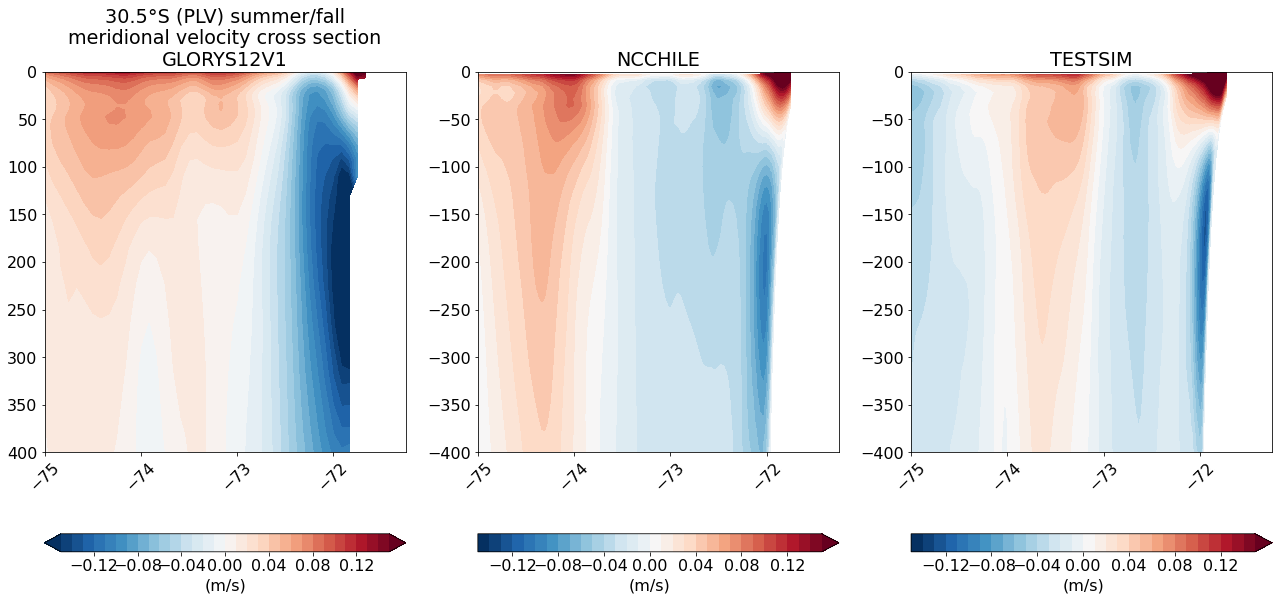

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(22,10))
plt.rc('font',size=16)
cmap = 'RdBu_r'
vmin,vmax=-0.15,0.15
cross_sections_means['glorys']['vo'].plot.contourf(ax=ax[0], levels=np.arange(vmin,vmax+0.01,0.01), cmap=cmap, cbar_kwargs={'label':'(m/s)', 'orientation':'horizontal'})
ax[0].invert_yaxis()
ax[0].set_xlim(-75,-71.25)
ax[0].set_ylim(400,0)

cross_sections_means['ncchile'].dropna('xi_rho').v.plot.contourf(y='z', ax=ax[1],x='lon_rho', levels=np.arange(vmin,vmax+0.01,0.01), cmap=cmap, cbar_kwargs={'label':'(m/s)', 'orientation':'horizontal'})
ax[1].set_xlim(-75, -71.25)
ax[1].set_ylim(-400,0)


cross_sections_means['testsim'].dropna('xi_rho').v.plot.contourf(y='z', ax=ax[2], x='lon_rho', levels=np.arange(vmin,vmax+0.01,0.01), cmap=cmap, cbar_kwargs={'label':'(m/s)', 'orientation':'horizontal'})
ax[2].set_xlim(-75, -71.25)
ax[2].set_ylim(-400,0)


titles = ['30.5°S (PLV) summer/fall\nmeridional velocity cross section\nGLORYS12V1', 'NCCHILE', 'TESTSIM']
for i,axis in enumerate(ax.ravel()):
    axis.set_xlabel('')
    axis.set_ylabel('')
    axis.set_title(titles[i])
    axis.tick_params(axis='x', rotation=45)

---